In [29]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [30]:
model_input_size = (224,224,3)
seed = 32
batch_size = 16 # Change this shit pag sasabog na yung GPU
exercise_type=['LumbarSideBends','QuadrupedThoracicRotation','SupineNeckLift']

In [31]:
# All Constant
train_folder = r'D:\MAPUA\THESIS2_REV\tomakemodel_frames\2nd_iteration\Training'
test_folder = r'D:\MAPUA\THESIS2_REV\tomakemodel_frames\2nd_iteration\Testing'
validation_folder = r'D:\MAPUA\THESIS2_REV\tomakemodel_frames\2nd_iteration\Validation'



Found 5540 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(224, 224, 3)


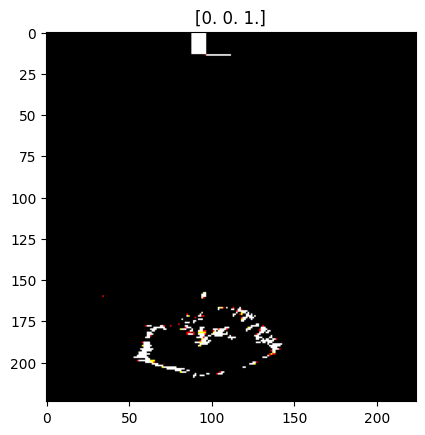

In [32]:
train_generator = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
)

train_data = train_generator.flow_from_directory(
    train_folder,
    target_size= model_input_size[:2],
    classes= exercise_type,
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
)

images,labels=next(train_data)
plt.imshow(images[1])
plt.title(labels[1])
print(images[1].shape)


Found 1030 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(224, 224, 3)


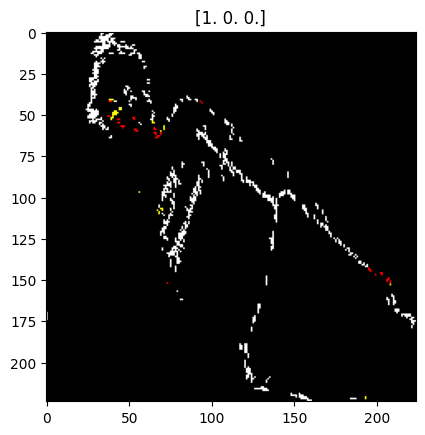

: 

In [33]:
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_data = test_generator.flow_from_directory(
    test_folder,
    target_size= model_input_size[:2],
    classes= exercise_type,
    batch_size = batch_size,
    shuffle = False,

)

images,labels=next(test_data)
plt.imshow(images[0])
plt.title(labels[0])
print(images[0].shape)


Found 1600 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(224, 224, 3)


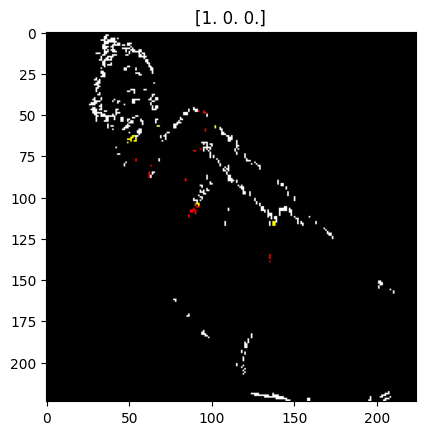

In [25]:
validation_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

validation_data = validation_generator.flow_from_directory(
    validation_folder,
    target_size= model_input_size[:2],
    classes= exercise_type,
    batch_size = batch_size,
    shuffle = False,

)

images,labels=next(validation_data)
plt.imshow(images[0])
plt.title(labels[0])
print(images[0].shape)


Mobile Net


In [26]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense
import tensorflow as tf

# Load the MobileNet V3 Small model with pre-trained ImageNet weights
mobilenet_v3_small = MobileNetV3Small(
    include_top=False, 
    weights='imagenet', 
    input_shape=model_input_size,  # model_input_size should be (224, 224, 3) as per your current setup
    pooling='avg'  # Use global average pooling
)

# Freeze the base model to prevent training its weights
mobilenet_v3_small.trainable = False

# Show the summary of the base model
mobilenet_v3_small.summary()

# Add custom layers on top of MobileNet V3 Small
x = mobilenet_v3_small.output
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(1024, activation='relu')(x)  # Connected to the previous dense layer
output = Dense(len(exercise_type), activation='softmax')(x)  # Output layer based on the number of exercise types

# Define the new model
model = tf.keras.Model(inputs=mobilenet_v3_small.input, outputs=output)

# Show the summary of the final model
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate as needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                   

In [27]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, verbose=1, mode="min", restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='model.h5', save_best_only=True, monitor="val_loss", mode="min"
)

history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    callbacks=[early_stopping, checkpoint],
)

Epoch 1/10
347/347 [==============================] - 94s 260ms/step - loss: 0.0638 - accuracy: 0.9774 - val_loss: 3.4340 - val_accuracy: 0.6775
Epoch 2/10
347/347 [==============================] - 54s 156ms/step - loss: 0.0470 - accuracy: 0.9850 - val_loss: 4.2409 - val_accuracy: 0.6781
Epoch 3/10
347/347 [==============================] - 54s 156ms/step - loss: 0.0315 - accuracy: 0.9908 - val_loss: 4.5536 - val_accuracy: 0.6781
Epoch 4/10
347/347 [==============================] - 54s 156ms/step - loss: 0.0255 - accuracy: 0.9912 - val_loss: 5.4660 - val_accuracy: 0.6781
Epoch 5/10
347/347 [==============================] - 54s 156ms/step - loss: 0.0306 - accuracy: 0.9897 - val_loss: 6.3837 - val_accuracy: 0.6781
Epoch 6/10
347/347 [==============================] - 54s 156ms/step - loss: 0.0242 - accuracy: 0.9915 - val_loss: 6.9809 - val_accuracy: 0.6781
Epoch 6: early stopping


Save Model

In [28]:
model = tf.keras.models.load_model("model.h5")
model.save("LucasKanadeModel_ver4_SMALL.h5")